In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from collections import deque

# Camera Calibration

1) Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

In [2]:
# Calibrate the camera to remove distortions
def calibrate_camera(images, pattern, obj_points, img_points):
    nx = pattern[1] # the number of inside corners in x
    ny = pattern[0] # the number of inside corners in y
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny,0:nx].T.reshape(-1,2) # x, y coordinates
    
    for fname in images:
        # Read in each image
        img = mpimg.imread(fname)

        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (ny,nx), None)
        
        # If corners are found, add object points and image points
        if ret == True:
            img_points.append(corners)
            obj_points.append(objp)
            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (pointY,pointX), corners, ret)
            #plt.imshow(img)
        
    # Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    
    return mtx, dist

In [3]:
# Object points and image points to undistort image later
import glob
images = glob.glob('camera_cal/calibration*.jpg')
pattern = (9, 6)
obj_points = []
img_points = []
mtx, dist = calibrate_camera(images, pattern, obj_points, img_points)

In [4]:
# Undistort images with distortion matrix
def undistort(img, mtx, dist):
    # Undistorting an image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

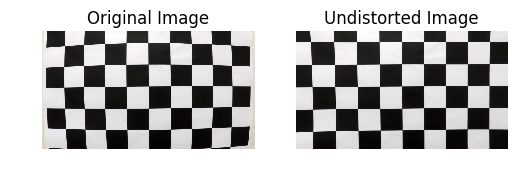

In [5]:
# Read 1 of the image that was used for calibration
dist_image = plt.imread('camera_cal/calibration1.jpg')
# Undistort the image
undist_image = undistort(dist_image, mtx, dist)
# Display the original and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(dist_image)
ax1.set_title('Original Image')
ax1.axis('off')
ax2.imshow(undist_image)
ax2.set_title('Undistorted Image')
ax2.axis('off')
f.savefig('output_images/undistort_output.jpg', bbox_inches='tight')

# Pipeline (test images)

1) Provide an example of a distortion-corrected image.

In [6]:
test1_dist = plt.imread('test_images/test1.jpg')
test1_undist = undistort(test1_dist, mtx, dist)

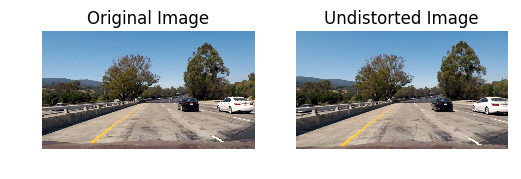

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(test1_dist)
ax1.set_title('Original Image')
ax1.axis('off')
ax2.imshow(test1_undist)
ax2.set_title('Undistorted Image')
ax2.axis('off')
f.savefig('output_images/undistort_image.jpg', bbox_inches='tight')

2) Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

In [8]:
# Color and gradient threshold
def threshold_image(image):
    # Convert RGB image to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # Threshold the color red in the image
    r = image[:,:,0]
    retval, r_output = cv2.threshold(r.astype('uint8'), 220, 255, cv2.THRESH_BINARY)
    # Threshold L and S in the image
    l = hls[:,:,1]
    retval, l_output = cv2.threshold(l.astype('uint8'), 40, 255, cv2.THRESH_BINARY)
    s = hls[:,:,2]
    retval, s_output = cv2.threshold(s.astype('uint8'), 95, 255, cv2.THRESH_BINARY)
    
    # Apply Sobel
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abssx = np.absolute(sobelx)
    scale_factor = np.max(abssx)/255
    abssx = (abssx/scale_factor).astype(np.uint8)
    retval, sxbinary = cv2.threshold(abssx, 20, 150, cv2.THRESH_BINARY)
    
    # Combine result
    result = np.zeros_like(r)
    result[((r_output == 255) | (s_output == 255)) & (l_output == 255) | (sxbinary > 0)] = 255
    
    return np.dstack((result,result,result))

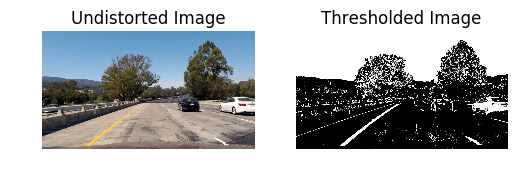

In [9]:
image_dist = plt.imread('test_images/test1.jpg')
image_undist = undistort(image_dist, mtx, dist)
thresh_image = threshold_image(image_undist)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_undist)
ax1.set_title('Undistorted Image')
ax1.axis('off')
ax2.imshow(thresh_image)
ax2.set_title('Thresholded Image')
ax2.axis('off')
f.savefig('output_images/binary_combo_example.jpg', bbox_inches='tight')

3) Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

In [10]:
# Mask regions that are not to be considered for lane lines
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [11]:
# Take in hough lines as parameter and find the lane lines
def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    img_shape = img.shape
    # Store the slopes of all the lines detected as left/right lane lines
    left_slopes = []
    right_slopes = []
    # Store the intersections of all the lines detected as left/right lane lines
    left_intercs = []
    right_intercs = []
    
    # Iterate through the lines detected
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                # Draw lines that are found (without extrapolating) (for testing purposes)
                # cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                # Calculate slope of line
                slope = (y2-y1)/(x2-x1)
                # Consider left/right lane if both points of line are located at the left/right side of image
                min_x = min(x1, x2)
                max_x = max(x1, x2)
                # Make sure slope and point is within range for it to be classified as right/left
                if 0.5 < slope < 0.8 and min_x > (img_shape[1]/2) and max_x > (img_shape[1]/2):
                    # Store slope of lines
                    right_slopes.append(slope)
                    # Calculate intersection
                    c = y1-slope*x1
                    x = (img_shape[0]-c)/slope
                    # Store intersection of lines
                    right_intercs.append(x)
                elif -0.8 < slope < -0.5 and min_x < (img_shape[1]/2) and max_x < (img_shape[1]/2):
                    left_slopes.append(slope)
                    c = y1 - slope*x1
                    x = (img_shape[0] - c) / slope
                    left_intercs.append(x)
    
    # Draw extrapolated line to a y location
    new_y = 450
    
    # Calculate left lane line slope and intersection if there is left lane line detected
    if len(left_slopes) != 0:
        # Average the slope of the lines
        left_slope = np.mean(left_slopes)
        left_interc = int(np.mean(left_intercs))
    # Calculate new parameters of line
    c_left = img_shape[0]-left_slope*left_interc
    new_x_left = int((new_y-c_left)/left_slope)
    # Draw extrapolated line
    cv2.line(img, (left_interc, img_shape[0]), (new_x_left, new_y), color, thickness)
    
    # Same as the above
    if len(right_slopes) != 0:
        right_slope = np.mean(right_slopes)
        right_interc = int(np.mean(right_intercs))
    c_right = img_shape[0]-right_slope*right_interc
    new_x_right = int((new_y-c_right)/right_slope)
    cv2.line(img, (right_interc, img_shape[0]), (new_x_right, new_y), color, thickness)
    
    # Return the left and right line
    return ((left_interc, img_shape[0]), (new_x_left, new_y)), ((right_interc, img_shape[0]), (new_x_right, new_y))

In [12]:
# Apply hough lines
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    left_line, right_line = draw_lines(line_img, lines)
    return line_img, left_line, right_line

In [13]:
# Combine image
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [14]:
dir_name = 'test_images/'
file_name = 'straight_lines1.jpg'

# Path of the image
img_dir = dir_name + file_name

# Read image
image = mpimg.imread(img_dir)
# Undistorted image
undist_image = undistort(image, mtx, dist)
# Convert to gray image
gray = cv2.cvtColor(undist_image, cv2.COLOR_RGB2GRAY)
# Apply gaussian blur to image
blur_gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Mask the edges
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(imshape[1]*24/50, imshape[0]*6/10), \
                      (imshape[1]*26/50, imshape[0]*6/10), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)

# Hough transform
# Distance resolution in pixels of the Hough grid
rho = 2
# Angular resolution in radians of the Hough grid
theta = np.pi/180
# Minimum number of votes (intersections in Hough grid cell)
threshold = 40
# Minimum number of pixels making up a line
min_line_length = 100
# Maximum gap in pixels between connectable line segments
max_line_gap = 150
# Run Hough on edge detected image to get lines
line_img, left_line, right_line = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

# Draw the lines on the edge image
result_img = weighted_img(line_img, image)

img_shape = image.shape
# Offset the image to have 200 pixels on the left and right spacing on the lane lines
offset = 200
src = np.float32([left_line[0], left_line[1], right_line[1], right_line[0]])
dst = np.float32([[offset, img_shape[0]], [offset, 0], [img_shape[1]-offset, 0], [img_shape[1]-offset, img_shape[0]]])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undist_image, M, (img_shape[1], img_shape[0]))

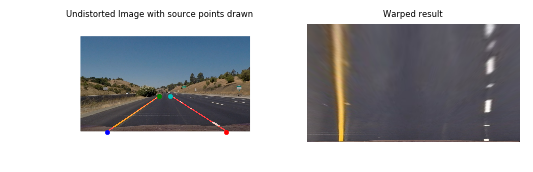

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(result_img)
ax1.set_title('Undistorted Image with source points drawn', fontsize=6)
ax1.axis('off')
ax1.plot(left_line[0][0], left_line[0][1], '.')
ax1.plot(left_line[1][0], left_line[1][1], '.')
ax1.plot(right_line[0][0], right_line[0][1], '.')
ax1.plot(right_line[1][0], right_line[1][1], '.')
ax2.imshow(warped)
ax2.set_title('Warped result', fontsize=6)
ax2.axis('off')
f.savefig('output_images/warped_straight_lines.jpg', bbox_inches='tight')

4) Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

In [16]:
# Find the left and right lane lines
def find_peaks(hist, width=400, stride=5):
    max_point = 0
    # The lane width is 880 pixels wide
    lane_width = 880
    # The bound of the sliding window
    bound = int(hist.shape[0] / 2)
    # Slide the 2 windows
    for i in range(0, bound+1, stride):
        # Sum the pixels in the 2 sliding windows
        cur = sum(hist[i:i+width]) + sum(hist[i+lane_width:i+lane_width+width])
        # Record the left and right lanes if it has more pixels than the current max
        if cur > max_point:
            max_point = cur
            left_peak = (i, i+width)
            right_peak = (i+lane_width, i+lane_width+width)
    # Return left and right peak
    return [left_peak, right_peak]

In [17]:
# Mask images using the left and right lane boundary and return the points for left and right lane
def mask_lane(thresh_image, left_range, right_range):
    img = np.zeros_like(thresh_image)
    # Mask image to get only pixels classified as left lane pixels
    img[:, left_range[0]:left_range[1], 0] |= thresh_image[:, left_range[0]:left_range[1], 0]
    # Mask image to get only pixels classified as right lane pixels
    img[:, right_range[0]:right_range[1], 2] |= thresh_image[:, right_range[0]:right_range[1], 2]
    # Get points only for pixels on image that are non-zero
    left_points = np.nonzero(img[:,:,0])
    right_points = np.nonzero(img[:,:,2])
    # Return the points
    return left_points[1], left_points[0], right_points[1], right_points[0]

In [18]:
dir_name = "test_images/"

file_name = 'test2.jpg'
img_dir = dir_name + file_name
image = mpimg.imread(img_dir)
undist_image = undistort(image, mtx, dist)

warped = cv2.warpPerspective(undist_image, M, (img_shape[1], img_shape[0]))
thresh_image = threshold_image(warped)

histogram = np.sum(thresh_image, axis=0)
# Finding the peak on the left
peaks = find_peaks(histogram[:, 0], width=380, stride=5)

left_range = peaks[0]
right_range = peaks[1]

xvals_left, yvals_left, xvals_right, yvals_right = mask_lane(thresh_image, left_range, right_range)
# Fit left curve
left_fit = np.polyfit(yvals_left, xvals_left, 2)
left_fitx = left_fit[0]*yvals_left**2 + left_fit[1]*yvals_left + left_fit[2]
# Fit right curve
right_fit = np.polyfit(yvals_right, xvals_right, 2)
right_fitx = right_fit[0]*yvals_right**2 + right_fit[1]*yvals_right + right_fit[2]

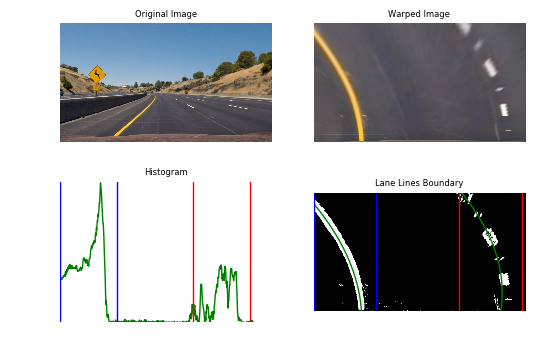

In [19]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# Display original image
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=6)
ax1.axis('off')

# Display warped image
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=6)
ax2.axis('off')

# Plot histogram graph and boundaries
ax3.plot(histogram[:,0], color='g')
ax3.plot((peaks[0][0], peaks[0][0]), (60000, 0), color='b')
ax3.plot((peaks[0][1], peaks[0][1]), (60000, 0), color='b')
ax3.plot((peaks[1][0], peaks[1][0]), (60000, 0), color='r')
ax3.plot((peaks[1][1], peaks[1][1]), (60000, 0), color='r')
ax3.set_title('Histogram', fontsize=6)
ax3.axis('off')

# Display thresholed image and the line fit
ax4.plot(left_fitx, yvals_left, color='green', linewidth=1)
ax4.plot(right_fitx, yvals_right, color='green', linewidth=1)
ax4.plot((peaks[0][0], peaks[0][0]), (720, 0), color='b')
ax4.plot((peaks[0][1], peaks[0][1]), (720, 0), color='b')
ax4.plot((peaks[1][0], peaks[1][0]), (720, 0), color='r')
ax4.plot((peaks[1][1], peaks[1][1]), (720, 0), color='r')
ax4.imshow(thresh_image)
ax4.set_title('Lane Lines Boundary', fontsize=6)
ax4.axis('off')

f.savefig('output_images/lines_boundary.jpg', bbox_inches='tight')

5) Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [20]:
# Take in image as input and output image with lane area drawn
def process_image(image, draw_text=True):
    # Undistort the image
    undist_image = undistort(image, mtx, dist)
    # Warp the image to have bird-view image
    warped = cv2.warpPerspective(undist_image, M, (img_shape[1], img_shape[0]))
    # Threshold the image
    thresh_image = threshold_image(warped)
    
    # Get the histogram of the image
    histogram = np.sum(thresh_image, axis=0)
    # Find the 2 peaks (left and right lanes)
    peaks = find_peaks(histogram[:, 0], width=380, stride=5)
    left_range = peaks[0]
    right_range = peaks[1]
    
    # Mask the image using the left and right lane boundaries (obtained from finding the peak)
    # and get the points of the pixels that fall within the boundaries
    xvals_left, yvals_left, xvals_right, yvals_right = mask_lane(thresh_image, left_range, right_range)
    # Fit left curve
    left_fit = np.polyfit(yvals_left, xvals_left, 2)
    left_fitx = left_fit[0]*yvals_left**2 + left_fit[1]*yvals_left + left_fit[2]
    # Fit right curve
    right_fit = np.polyfit(yvals_right, xvals_right, 2)
    right_fitx = right_fit[0]*yvals_right**2 + right_fit[1]*yvals_right + right_fit[2]

    # Get the points of the left and right lines
    left_pts = [list(a) for a in zip(left_fitx, yvals_left)]
    right_pts = [list(a) for a in zip(right_fitx, yvals_right)]

    # Create an image with zeros that is of the same size as original image
    img = np.zeros_like(thresh_image)

    # Combined the points and draw it on the image, and then unwarp the image back to the original
    left_pts.extend(right_pts[::-1])
    curved_img = cv2.fillPoly(img, np.int32([left_pts]), (0,255,0))
    warped = cv2.warpPerspective(curved_img, Minv, (img_shape[1], img_shape[0]))
    # Combine the image with the drawn lane lines with the original image
    res_image = weighted_img(warped, undist_image, β=0.3)
    
    # Draw the value of lane curvature and distance of vehicle to the center to the image
    if draw_text is True:
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/880 # meteres per pixel in x dimension
        
        # Get the curved radius in the real world
        left_fit_cr = np.polyfit(yvals_left*ym_per_pix, xvals_left*xm_per_pix, 2)
        right_fit_cr = np.polyfit(yvals_right*ym_per_pix, xvals_right*xm_per_pix, 2)
        y_eval = np.max(yvals_right)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*left_fit_cr[0])
        y_eval = np.max(yvals_right)
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                        /np.absolute(2*right_fit_cr[0])
        
        # Now our radius of curvature is in meters
        # print(left_curverad,right_curverad)
        average_curverad = (left_curverad+right_curverad)/2
        
        # Calculate how far the vehicle is from the center
        offset = (xvals_left[0] - 200 + xvals_right[0] - 1080) / 2
        # Vehicle is left of center
        if offset < 0:
            offset_meter = xm_per_pix * np.abs(offset)
            cv2.putText(res_image,'Vehicle is ' + str(round(offset_meter,2)) + 'm left of center', (25,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
        # Vehicle is right of center
        elif offset > 0:
            offset_meter = xm_per_pix * offset
            cv2.putText(res_image,'Vehicle is ' + str(round(offset_meter,2)) + 'm right of center', (25,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
        # Vehicle is in the center
        else:
            cv2.putText(res_image,'Vehicle is in the center', (25,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
        # Draw value of radius of curvature to image
        cv2.putText(res_image,'Radius of Curvature = ' + str(round(average_curverad,0)) + '(m)', (25,50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2)
    
    # Return resulting image
    return res_image

In [21]:
dir_name = "test_images/"

import os
# Process all the test images
for file_name in os.listdir(dir_name):
    file_name_split = file_name.split('_')
    # Do not proces images that has 'out' at the end of the file name
    if (file_name_split[len(file_name_split)-1] == 'out.jpg'):
        continue
    # Concatenate to get full directory
    img_dir = dir_name + file_name
    # Read the image
    image = plt.imread(img_dir)
    # Process the image
    res_image = process_image(image, draw_text=False)
    # Save thee image
    plt.imsave(dir_name + file_name.split('.')[0] + '_out.jpg', res_image)
    print('Saved file:', file_name)

Saved file: straight_lines1.jpg
Saved file: straight_lines2.jpg
Saved file: test1.jpg
Saved file: test2.jpg
Saved file: test3.jpg
Saved file: test4.jpg
Saved file: test5.jpg
Saved file: test6.jpg


5) Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

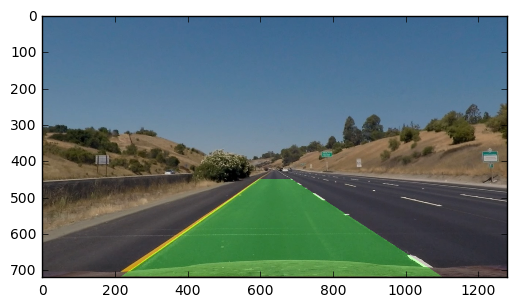

In [22]:
image = plt.imread(dir_name+'straight_lines1.jpg')
image_res = process_image(image, draw_text=False)
plt.imshow(image_res)
plt.imsave('output_images/example_output.jpg', image_res)

In [23]:
from moviepy.editor import VideoFileClip

Test it on video

In [24]:
# Read the video and run the 'process_image' function to all the frames
output_file = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
project_clip = clip.fl_image(process_image)
%time project_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [06:17<00:00,  3.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 6min 19s
